# Data Inspection

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tcn import TCN
from tensorflow import keras
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="google.protobuf.runtime_version")

## Basic Data Overview

In [2]:
# Paths
root = Path.cwd()
for _ in range(6):
    if (root / "data" / "raw" / "train").exists():
        break
    root = root.parent
PROJ = root
DATA = PROJ / "data" / "raw" / "train"
print("DATA exists:", DATA.exists())

DATA exists: True


# Data standardization (field orientation)

In [3]:
def standardize_by_play_direction(df):
    left = df["play_direction"].eq("left")
    # positions
    df.loc[left, "x"] = 120 - df.loc[left, "x"]
    df.loc[left, "y"] = 53.3 - df.loc[left, "y"]
    if "ball_land_x" in df: df.loc[left, "ball_land_x"] = 120 - df.loc[left, "ball_land_x"]
    if "ball_land_y" in df: df.loc[left, "ball_land_y"] = 53.3 - df.loc[left, "ball_land_y"]
    # angles
    if "dir" in df: df.loc[left, "dir"] = (df.loc[left, "dir"] + 180) % 360
    if "o"   in df: df.loc[left, "o"]   = (df.loc[left, "o"]   + 180) % 360
    return df

# Load all weeks (input + output)
def load_inputs_outputs(data_dir: Path):
    inp_weeks = []
    out_weeks = []
    for w in range(1, 19):
        week = f"w{w:02d}"
        # input
        df_in = pd.read_csv(data_dir / f"input_2023_{week}.csv")
        df_in = standardize_by_play_direction(df_in)
        df_in["week"] = week
        inp_weeks.append(df_in)
        # output
        df_out = pd.read_csv(data_dir / f"output_2023_{week}.csv")
        df_out["week"] = week
        out_weeks.append(df_out)
    inp_all = pd.concat(inp_weeks, ignore_index=True)
    df_output = pd.concat(out_weeks, ignore_index=True)
    return inp_all, df_output

inp_all, df_output = load_inputs_outputs(DATA)

# Map play_direction from standardized input - output, then standardize output
dir_map = (inp_all[["game_id", "play_id", "play_direction"]].drop_duplicates())

df_output = df_output.merge(dir_map, on=["game_id", "play_id"], how="left")
df_output = standardize_by_play_direction(df_output)

print("inp_all:", inp_all.shape, "df_output:", df_output.shape)

inp_all: (4880579, 24) df_output: (562936, 8)


# Feature engineering (velocities, distances, etc.)

## Self-based features

In [4]:
group_cols_full  = ["game_id", "play_id", "frame_id"]
player_key       = ["game_id", "play_id", "frame_id", "nfl_id"]
play_key         = ["game_id", "play_id"]

base = inp_all.copy().sort_values(player_key)

##### 1.a Self-based features: dx, dy, do, vx, vy, dist_to_ball, ball_dir#####
# frame-to-frame deltas (position)
base[["dx", "dy"]] = (base.groupby(["game_id", "play_id", "nfl_id"])[["x", "y"]].diff().fillna(0.0))

# frame-to-frame delta (orientation)
base["do"] = (base.groupby(["game_id", "play_id", "nfl_id"])["o"].diff().fillna(0.0))

# distance to ball landing
base["dist_to_ball"] = np.hypot(
    base["x"] - base["ball_land_x"],
    base["y"] - base["ball_land_y"])

# direction from player → ball landing spot (unit vector)
angle_to_ball = np.arctan2(
    base["ball_land_y"] - base["y"],
    base["ball_land_x"] - base["x"])
base["ball_dirx"] = np.cos(angle_to_ball)
base["ball_diry"] = np.sin(angle_to_ball)

# velocity components from speed + dir
rad_dir = np.deg2rad(base["dir"])
base["vx"] = base["s"] * np.cos(rad_dir)
base["vy"] = base["s"] * np.sin(rad_dir)

# second derivatives (accelerations in x,y)
base[["ddx", "ddy"]] = (
    base.groupby(["game_id", "play_id", "nfl_id"])[["dx", "dy"]].diff().fillna(0.0))

## QB features: location + distance to QB

In [5]:
# ---------- 1.b QB features: location + distance to QB ----------
# QB is usually labelled "Passer" in player_role
qb = (base[base["player_role"] == "Passer"]
    [group_cols_full + ["x", "y"]]
    .rename(columns={"x": "x_qb", "y": "y_qb"}))
base = base.merge(qb, on=group_cols_full, how="left")

# distance to QB
base["dist_qb"] = np.hypot(
    base["x"] - base["x_qb"],
    base["y"] - base["y_qb"])


# ---------- 1.bbis Targeted Receiver features: distancia al TR ----------
def add_dist_to_targeted_receiver(df: pd.DataFrame) -> pd.DataFrame:
    # posición del Targeted Receiver por frame
    tr = (
        df[df["player_role"] == "Targeted Receiver"]
        [group_cols_full + ["x", "y"]]
        .rename(columns={"x": "x_tr", "y": "y_tr"}))

    # merge a todos los jugadores en ese frame
    df = df.merge(tr, on=group_cols_full, how="left")

    # distancia al Targeted Receiver
    df["dist_to_tr"] = np.hypot(
        df["x"] - df["x_tr"],
        df["y"] - df["y_tr"])
    return df
base = add_dist_to_targeted_receiver(base)

## Distance to nearest opponent (offense ↔ defense)

In [6]:
# ---------- 1.c Distance to nearest opponent (offense ↔ defense) ----------
def nearest_opponent_distance(df: pd.DataFrame, side_col: str = "player_side") -> pd.DataFrame:
    """Return distance to closest opponent for each (game, play, frame, nfl_id)."""
    # split offense / defense
    off  = df[df[side_col] == "Offense"]
    deff = df[df[side_col] == "Defense"]

    # Offense -> nearest defender
    off_m = off.merge(
        deff[["game_id", "play_id", "frame_id", "nfl_id", "x", "y"]],
        on=["game_id", "play_id", "frame_id"],
        suffixes=("", "_opp"))
    off_m["dist_opp"] = np.hypot(
        off_m["x"] - off_m["x_opp"],
        off_m["y"] - off_m["y_opp"])
    off_min = (
        off_m.groupby(player_key)["dist_opp"]
             .min()
             .reset_index())

    # Defense -> nearest offensive player
    deff_m = deff.merge(
        off[["game_id", "play_id", "frame_id", "nfl_id", "x", "y"]],
        on=["game_id", "play_id", "frame_id"],
        suffixes=("", "_opp"))
    deff_m["dist_opp"] = np.hypot(
        deff_m["x"] - deff_m["x_opp"],
        deff_m["y"] - deff_m["y_opp"])
    deff_min = (
        deff_m.groupby(player_key)["dist_opp"]
              .min()
              .reset_index())

    # combine offense + defense
    both = pd.concat([off_min, deff_min], ignore_index=True)
    return both

nearest = nearest_opponent_distance(base)
base = base.merge(nearest, on=player_key, how="left")
base.rename(columns={"dist_opp": "dist_nearest_opp"}, inplace=True)

## One-hot encode side and role

In [7]:
base = pd.get_dummies(
    base,
    columns=["player_side", "player_role"],
    drop_first=True)

#Keep only players we have to predict
seq_df = base[base["player_to_predict"]].copy()
seq_df = seq_df.sort_values(player_key)

# Restrict outputs to those players
keys_pp = seq_df[["game_id", "play_id", "nfl_id"]].drop_duplicates()
df_out_pp = df_output.merge(
    keys_pp,
    on=["game_id", "play_id", "nfl_id"],
    how="inner"
).sort_values(player_key)

# Build sequences with relative coordinates + rich features

##  Sequence length diagnostics (pre-throw vs output)

In [10]:
# Pre-throw frames per player_to_predict (input)
in_lengths = (seq_df.groupby(["game_id", "play_id", "nfl_id"])["frame_id"].nunique())

# Output frames per player_to_predict (output)
out_lengths = (df_out_pp.groupby(["game_id", "play_id", "nfl_id"])["frame_id"].max())

# 2) Summary table (inputs vs outputs)
def length_summary(s: pd.Series, name: str) -> pd.Series:
    """Compute basic stats + quantiles for a length series."""
    return pd.Series(
        {"count": s.shape[0], "min": s.min(), "max": s.max(),
         "mean": s.mean(), "median": s.median(),
         "q10": s.quantile(0.10), "q25": s.quantile(0.25),
         "q50": s.quantile(0.50), "q75": s.quantile(0.75),
         "q90": s.quantile(0.90),}, name=name,)

summary_in  = length_summary(in_lengths,  "pre_throw_len")
summary_out = length_summary(out_lengths, "output_len")

length_stats_table = pd.concat([summary_in, summary_out], axis=1)
print("\nLength statistics (per sequence)")
print(length_stats_table)

# 3) Table of how many sequences survive each T_IN / MAX_OUT
candidate_T_IN  = [8, 10, 15, 20, 30, 40]
candidate_T_OUT = [5, 10, 20, 30, 40]
rows = []
n_seq = in_lengths.shape[0]
for t_in in candidate_T_IN:
    kept_in = (in_lengths >= t_in).sum()
    frac_in = kept_in / n_seq
    rows.append({"type": "T_IN", "value": t_in, "n_kept": kept_in, "frac_kept": frac_in})
for t_out in candidate_T_OUT:
    kept_out = (out_lengths >= t_out).sum()
    frac_out = kept_out / n_seq   # same denominator so you can compare
    rows.append({"type": "T_OUT", "value": t_out, "n_kept": kept_out, "frac_kept": frac_out})
length_choice_table = pd.DataFrame(rows)

print("\nSequences kept for candidate T_IN and T_OUT")
print(length_choice_table.sort_values(["type", "value"]))


Length statistics (per sequence)
        pre_throw_len    output_len
count     46045.00000  46045.000000
min           8.00000      5.000000
max         123.00000     94.000000
mean         28.30796     12.225779
median       27.00000     11.000000
q10          19.00000      7.000000
q25          22.00000      8.000000
q50          27.00000     11.000000
q75          33.00000     14.000000
q90          39.00000     20.000000

Sequences kept for candidate T_IN and T_OUT
     type  value  n_kept  frac_kept
0    T_IN      8   46045   1.000000
1    T_IN     10   46022   0.999500
2    T_IN     15   45628   0.990944
3    T_IN     20   40272   0.874623
4    T_IN     30   16768   0.364165
5    T_IN     40    4075   0.088500
6   T_OUT      5   46045   1.000000
7   T_OUT     10   28227   0.613031
8   T_OUT     20    5194   0.112803
9   T_OUT     30     410   0.008904
10  T_OUT     40      23   0.000500


## Final choice of T_IN / MAX_OUT for the mode

In [11]:
T_IN  = 10       # input: last 10 pre-throw frames
# We compared T_IN = 10 vs 15; T_IN = 10 performed slightly better (RMSE 1.22 vs 1.24), so we used 10
MAX_OUT = 20     # predict up to 20 frames into the future

# List of frame-level features (without x,y; add x_rel,y_rel later)
frame_features = [
    # kinematics
    "s", "a", "o", "dir",
    "vx", "vy",
    "dx", "dy", "ddx", "ddy",
    # ball / qb / opponent / targeted receiver
    "dist_to_ball",
    "ball_dirx", "ball_diry",
    "x_qb", "y_qb", "dist_qb",
    "dist_nearest_opp",
    "dist_to_tr", 
    "num_frames_output",]

# dummy columns for side / role
dummy_cols = [
    c for c in seq_df.columns
    if c.startswith("player_side_") or c.startswith("player_role_")]
frame_features = frame_features + dummy_cols

print("Number of frame features (without x_rel,y_rel):", len(frame_features))


# Build input/output sequences per (game_id, play_id, nfl_id)
X_list   = []
Y_list   = []
start_xy = []   # absolute starting point (x0, y0)
lengths  = []   # actual output length per sequence (≤ MAX_OUT)
meta     = []   # (game_id, play_id, nfl_id, side)

for (g, p, n), g_in in seq_df.groupby(["game_id", "play_id", "nfl_id"]):
    # corresponding future (output) frames for this player
    g_out = df_out_pp[
        (df_out_pp["game_id"] == g) &
        (df_out_pp["play_id"] == p) &
        (df_out_pp["nfl_id"] == n)
    ].sort_values("frame_id")

    # need enough input frames and at least 1 output frame
    if len(g_in) < T_IN or len(g_out) < 1:
        continue
    # last T_IN pre-throw frames
    g_in_last = g_in.tail(T_IN).copy()

    # actual output length (capped by MAX_OUT)
    actual_len = min(len(g_out), MAX_OUT)
    g_out_first = g_out.head(actual_len).copy()

    # starting point = last pre-throw frame (absolute coords)
    x0, y0 = g_in_last.iloc[-1][["x", "y"]]
    start_xy.append([x0, y0])

    # relative coordinates for inputs
    g_in_last["x_rel"] = g_in_last["x"] - x0
    g_in_last["y_rel"] = g_in_last["y"] - y0

    # build feature matrix for inputs
    feat_df = g_in_last[frame_features + ["x_rel", "y_rel"]]

    # skip sequence if ANY NaN in these features
    if feat_df.isna().any().any():
        start_xy.pop()
        continue
    Xin = feat_df.to_numpy(dtype=np.float32)

    # targets: relative future trajectory (output)
    Y_abs = g_out_first[["x", "y"]].to_numpy(dtype=np.float32)
    Y_rel = Y_abs - np.array([[x0, y0]], dtype=np.float32)

    # pad to MAX_OUT if needed (remaining frames = zeros)
    if actual_len < MAX_OUT:
        padding = np.zeros((MAX_OUT - actual_len, 2), dtype=np.float32)
        Y_rel = np.vstack([Y_rel, padding])

    X_list.append(Xin)
    Y_list.append(Y_rel)
    lengths.append(actual_len) 
    side = "Offense" if g_in["player_side_Offense"].iloc[0] == 1 else "Defense"
    meta.append((g, p, n, side))

# Stack into final arrays
X_seq    = np.stack(X_list)              # (N, T_IN, F)
Y_seq    = np.stack(Y_list)              # (N, MAX_OUT, 2)
start_xy = np.array(start_xy, np.float32)
lengths  = np.array(lengths, np.int32)  

print("X_seq shape:", X_seq.shape)
print("Y_seq shape:", Y_seq.shape)
print("Number of sequences:", len(meta))
print("Lengths (min/max/mean):", lengths.min(), lengths.max(), lengths.mean())  # ✅ NEW

# Final NaN sanity check
X_flat = X_seq.reshape(-1, X_seq.shape[-1])
print("Any NaNs in X_seq?", np.isnan(X_flat).any())
print("Any NaNs in Y_seq?", np.isnan(Y_seq).any())

Number of frame features (without x_rel,y_rel): 23
X_seq shape: (46012, 10, 25)
Y_seq shape: (46012, 20, 2)
Number of sequences: 46012
Lengths (min/max/mean): 5 20 11.733808571676954
Any NaNs in X_seq? False
Any NaNs in Y_seq? False


# Train/validation split + feature scaling

In [15]:
# Basic shapes
N, T_IN, F = X_seq.shape
_, T_OUT, _ = Y_seq.shape
print("T_IN, F =", T_IN, F, "| T_OUT =", T_OUT)

# --------------TRAIN/VAL SPLIT (same permutation for X, Y, start_xy, lengths)---------
X_train, X_val, Y_train, Y_val, start_train, start_val, len_train, len_val = train_test_split(
    X_seq, Y_seq, start_xy, lengths, test_size=0.2, random_state=42)

# meta in same original order as X_seq/Y_seq
meta_arr = np.array(meta, dtype=object)

# Separate split for meta, but same random_state and length → same permutation
_, meta_val = train_test_split(meta_arr, test_size=0.2, random_state=42)

# Side labels (Offense / Defense) for validation sequences
player_side_val = np.array([m[3] for m in meta_val])

# --------------Feature standardization (only on X, per-feature)--------
# Flatten time dimension for mean/std (T_IN * N_train, F)
X_train_flat = X_train.reshape(-1, F)
feat_mean = X_train_flat.mean(axis=0)
feat_std  = X_train_flat.std(axis=0) + 1e-6 # avoid division by zero

def scale_X(X):
    """Standardize features using train mean/std."""
    return (X - feat_mean) / feat_std

X_train_sc = scale_X(X_train)
X_val_sc   = scale_X(X_val)

# Targets kept in original units (yards, relative coords)
Y_train_sc = Y_train
Y_val_sc   = Y_val

T_IN, F = 10 25 | T_OUT = 20


# Model – TCN multi-step predictor 

## Masked loss

In [17]:
# MASKED LOSS FUNCTION
class MaskedMSE(keras.losses.Loss):
    """MSE loss that only considers valid frames (non-padded)."""
    def __init__(self, name="masked_mse"):
        super().__init__(name=name)
    def call(self, y_true, y_pred):
        # y_true, y_pred: (batch, MAX_OUT, 2)
        # Squared error per frame & coordinate
        squared_diff = tf.square(y_true - y_pred)
        # Mask: frames where both coords == 0 are padding
        mask = tf.cast(
            tf.logical_or(
                tf.abs(y_true[:, :, 0]) > 1e-6,
                tf.abs(y_true[:, :, 1]) > 1e-6,
            ),
            tf.float32,
        )  # (batch, MAX_OUT)
        mask = tf.expand_dims(mask, -1)  # (batch, MAX_OUT, 1)
        # Apply mask
        masked_loss = squared_diff * mask
        # Average over *valid* coordinates only
        sum_loss   = tf.reduce_sum(masked_loss)
        num_valid  = tf.reduce_sum(mask) + 1e-8
        return sum_loss / num_valid

## TCN architecture

In [19]:
inputs = keras.Input(shape=(T_IN, F))
x = TCN(
    nb_filters=64,
    kernel_size=3,
    dilations=[1, 2, 4, 8],
    dropout_rate=0.1,
    return_sequences=False,
)(inputs)

x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(MAX_OUT * 2)(x)
outputs = keras.layers.Reshape((MAX_OUT, 2))(x)

tcn_model = keras.Model(inputs, outputs)
tcn_model.summary()

# MODEL COMPILATION
tcn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=MaskedMSE(),)

history = tcn_model.fit(
    X_train_sc, Y_train_sc,
    validation_data=(X_val_sc, Y_val_sc),
    epochs=15,
    batch_size=128,)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 64)             │        92,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 20, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,472 (415.91 KB)

 Trainable params: 106,472 (415.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 3.9064 - val_loss: 1.0623
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.2018 - val_loss: 0.8065
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.9750 - val_loss: 0.7192
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.8798 - val_loss: 0.6931
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.7954 - val_loss: 0.6599
Epoch 6/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.7599 - val_loss: 0.6750
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.7191 - val_loss: 0.6329
Epoch 8/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.6810 - val_loss: 0.6084
Epoch 9/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.6625 - val_loss: 0.6226
Epoch 10/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.6355 - val_loss: 0.6008
Epoch 11/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.6247 - val_loss: 0.5718
Epoch 12/15
288/288 ━━━━━━━━━━━━━━━━━━━━

## Training history plots + # Best epoch summary

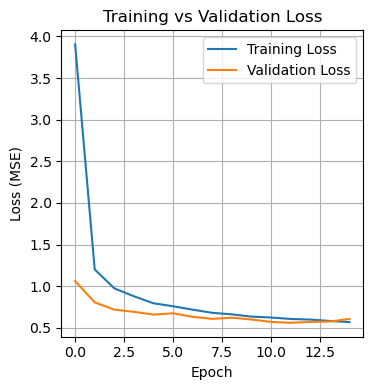

Best Epoch: 12/15
Training Loss: 0.607232
Validation Loss: 0.561243
Overfitting Gap: -0.045990
Model generalizing well!


In [21]:
# Plot training & validation loss
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# PRINT BEST EPOCH INFO
best_epoch = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_epoch]
best_train_loss = history.history['loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}/{len(history.history['loss'])}")
print(f"Training Loss: {best_train_loss:.6f}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Overfitting Gap: {best_val_loss - best_train_loss:.6f}")

if best_val_loss > best_train_loss * 1.5:
    print("Warning: Possible overfitting detected!")
elif best_val_loss < best_train_loss:
    print("Model generalizing well!")

## Evaluation RMSE

In [22]:
# Predictions on validation set
Y_val_pred = tcn_model.predict(X_val_sc)  # (N_val, MAX_OUT, 2), relative coords
Y_val_true = Y_val                        # (N_val, MAX_OUT, 2)

# RMSE in (relative) yards
def rmse_masked(y_true, y_pred, lengths):
    """RMSE over valid frames only (uses per-sequence length)."""
    total_sq_dist = 0.0
    total_frames  = 0
    for i in range(len(lengths)):
        L = lengths[i]
        diff   = y_true[i, :L] - y_pred[i, :L]          # (L, 2)
        sq_dist = np.sum(diff**2, axis=-1)              # dx^2 + dy^2 per frame
        total_sq_dist += sq_dist.sum()
        total_frames  += L
    return np.sqrt(total_sq_dist / total_frames)

# Overall RMSE (relative coordinates)
rmse_overall = rmse_masked(Y_val_true, Y_val_pred, len_val)
print(f"TCN RMSE (masked, relative): {rmse_overall:.3f}")

# RMSE in absolute field coordinates (more intuitive)
Y_val_true_abs = start_val[:, None, :] + Y_val_true
Y_val_pred_abs = start_val[:, None, :] + Y_val_pred

rmse_abs = rmse_masked(Y_val_true_abs, Y_val_pred_abs, len_val)
print(f"TCN RMSE (masked, absolute): {rmse_abs:.3f}")

# Split offense / defense
off_idx = np.where(player_side_val == "Offense")[0]
def_idx = np.where(player_side_val == "Defense")[0]

rmse_offense = rmse_masked(
    Y_val_true[off_idx],
    Y_val_pred[off_idx],
    len_val[off_idx],)
rmse_defense = rmse_masked(
    Y_val_true[def_idx],
    Y_val_pred[def_idx],
    len_val[def_idx],)

print(f"RMSE (Offense):  {rmse_offense:.3f}")
print(f"RMSE (Defense):  {rmse_defense:.3f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
TCN RMSE (masked, relative): 0.780
TCN RMSE (masked, absolute): 0.780
RMSE (Offense):  0.621
RMSE (Defense):  0.838


# Visualizations

In [ ]:
# Build dataframe of trajectories for visualization
rows = []
for i in range(len(len_val)):
    game_id, play_id, nfl_id, side = meta_val[i]
    L = len_val[i]
    for t in range(L):
        rows.append({
            "game_id": game_id,
            "play_id": play_id,
            "nfl_id":  nfl_id,
            "side":    side,
            "frame_id": t,
            "x_actual": Y_val_true_abs[i, t, 0],
            "y_actual": Y_val_true_abs[i, t, 1],
            "x_pred":   Y_val_pred_abs[i, t, 0],
            "y_pred":   Y_val_pred_abs[i, t, 1],
        })

tcn_tracks = pd.DataFrame(rows)

# Helper: sample a subset of trajectories to avoid overplotting
def sample_tracks(tracks_df, side, n_tracks=60, step=1):
    """
    tracks_df: DataFrame with columns game_id, play_id, nfl_id, side, frame_id,
               x_actual, y_actual, x_pred, y_pred
    side:     "Offense" or "Defense"
    n_tracks: number of trajectories (players) to sample
    step:     keep every `step`-th frame (to thin in time)
    """
    # Filter by side
    df = tracks_df[tracks_df["side"] == side].copy()
    # Unique trajectories
    traj_keys = df[["game_id", "play_id", "nfl_id"]].drop_duplicates()
    # Sample some trajectories
    n_tracks = min(n_tracks, len(traj_keys))
    sampled_keys = traj_keys.sample(n_tracks, random_state=0)
    # Keep all frames of those trajectories
    plot_df = df.merge(
        sampled_keys,
        on=["game_id", "play_id", "nfl_id"],
        how="inner",)
    # Sort by time within each trajectory
    plot_df = plot_df.sort_values(
        ["game_id", "play_id", "nfl_id", "frame_id"])
    # Optional: thin in time
    if step > 1:
        plot_df = plot_df[plot_df["frame_id"] % step == 0]
    return plot_df

## Quiver plot – Defense

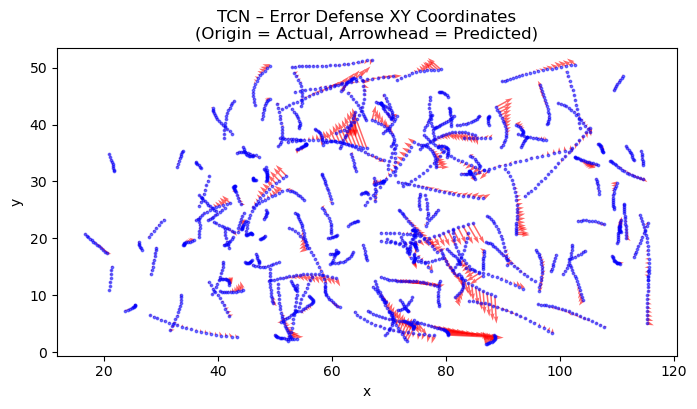

In [28]:
defense_plot_df = sample_tracks(tcn_tracks, side="Defense",
                                n_tracks=180, step=1)

actual_def = defense_plot_df[["x_actual", "y_actual"]].rename(
    columns={"x_actual": "x_defense", "y_actual": "y_defense"})
pred_def = defense_plot_df[["x_pred", "y_pred"]].rename(
    columns={"x_pred": "x_defense", "y_pred": "y_defense"})

plt.figure(figsize=(8, 4))
plt.quiver(
    actual_def['x_defense'], 
    actual_def['y_defense'],
    pred_def['x_defense'] - actual_def['x_defense'], 
    pred_def['y_defense'] - actual_def['y_defense'],
    angles='xy', scale_units='xy', scale=1,
    color='r', alpha=0.6)
plt.scatter(
    actual_def['x_defense'], 
    actual_def['y_defense'],
    color='b', alpha=0.5, s=3)
plt.xlabel('x'); plt.ylabel('y')
plt.xlim(0, 120); plt.ylim(0, 53.3)
plt.title('TCN – Error Defense XY Coordinates\n(Origin = Actual, Arrowhead = Predicted)')
plt.axis('equal')
plt.show()


## Quiver plot – Offense

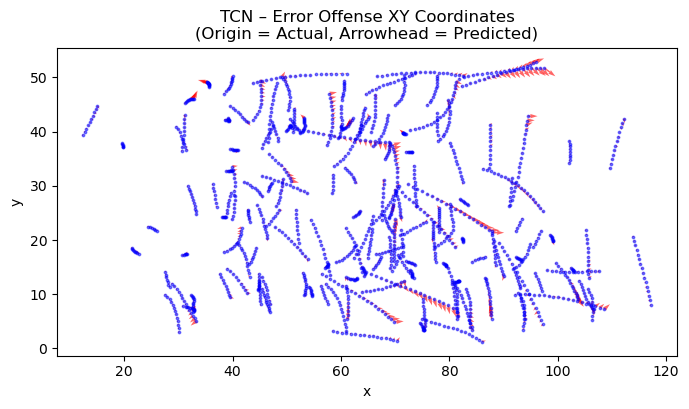

In [30]:
offense_plot_df = sample_tracks(
    tcn_tracks,
    side="Offense",
    n_tracks=160,  # reduce if still too dense (e.g. 40)
    step=1,        # or step=2 to thin frames
)

actual_off = offense_plot_df[["x_actual", "y_actual"]].rename(
    columns={"x_actual": "x_offense", "y_actual": "y_offense"})
pred_off = offense_plot_df[["x_pred", "y_pred"]].rename(
    columns={"x_pred": "x_offense", "y_pred": "y_offense"})

plt.figure(figsize=(8, 4))
plt.quiver(
    actual_off["x_offense"],
    actual_off["y_offense"],
    pred_off["x_offense"] - actual_off["x_offense"],
    pred_off["y_offense"] - actual_off["y_offense"],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="r",
    alpha=0.6,)
plt.scatter(
    actual_off["x_offense"],
    actual_off["y_offense"],
    color="b",
    alpha=0.5,
    s=3,)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.title("TCN – Error Offense XY Coordinates\n(Origin = Actual, Arrowhead = Predicted)")
plt.axis("equal")
plt.show()

## RMSE per prediction horizon

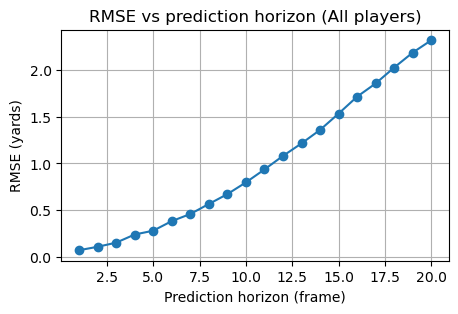

In [33]:
def rmse_per_horizon(y_true, y_pred, lengths, max_horizon=None):
    N, MAX_OUT, _ = y_true.shape
    if max_horizon is None:
        max_horizon = MAX_OUT
    horizons = []
    rmses = []
    for k in range(max_horizon):   # k = 0,1,2,... (frame index)
        # sequences that have at least (k+1) frames
        mask = lengths > k
        if not np.any(mask):
            continue  # no sequences with that horizon  
        diff = y_true[mask, k, :] - y_pred[mask, k, :]   # (n_k, 2)
        sq_dist = np.sum(diff**2, axis=-1)              # (n_k,), dx^2 + dy^2
        rmse_k = np.sqrt(np.mean(sq_dist))  
        horizons.append(k)
        rmses.append(rmse_k)
    
    return np.array(horizons), np.array(rmses)

# Overall RMSE per horizon (absolute coords)
h, rmse_h = rmse_per_horizon(Y_val_true_abs, Y_val_pred_abs, len_val, max_horizon=20)

plt.figure(figsize=(5,3))
plt.plot(h+1, rmse_h, marker="o")   # +1 to show frames as 1..20 instead of 0..19
plt.xlabel("Prediction horizon (frame)")
plt.ylabel("RMSE (yards)")
plt.title("RMSE vs prediction horizon (All players)")
plt.grid(True)
plt.show()

## RMSE per horizon by side (Offense / Defense)

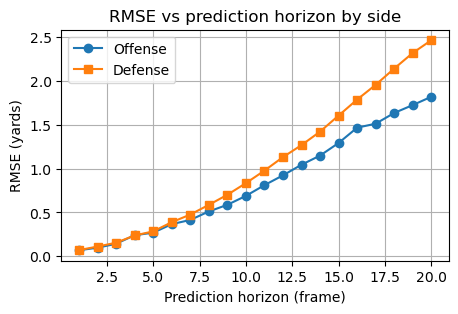

In [36]:
off_idx = np.where(player_side_val == "Offense")[0]
def_idx = np.where(player_side_val == "Defense")[0]
# Offense
h_off, rmse_off = rmse_per_horizon(
    Y_val_true_abs[off_idx],
    Y_val_pred_abs[off_idx],
    len_val[off_idx],
    max_horizon=20)

# Defense
h_def, rmse_def = rmse_per_horizon(
    Y_val_true_abs[def_idx],
    Y_val_pred_abs[def_idx],
    len_val[def_idx],
    max_horizon=20)

plt.figure(figsize=(5,3))
plt.plot(h_off+1, rmse_off, marker="o", label="Offense")
plt.plot(h_def+1, rmse_def, marker="s", label="Defense")
plt.xlabel("Prediction horizon (frame)")
plt.ylabel("RMSE (yards)")
plt.title("RMSE vs prediction horizon by side")
plt.grid(True)
plt.legend()
plt.show()